In [1]:
import torch
from dlc_practical_prologue import generate_pair_sets
import torch.nn as nn
from print_util import *
import matplotlib.pyplot as plt
import time

## 1. Generate raw data, process it

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [4]:
def generate_data_device(n, device='cpu'):
    train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(n)
    train_input = train_input.to(device=device)
    train_target = train_target.to(device=device)
    train_classes = train_classes.to(device=device)
    test_input = test_input.to(device=device)
    test_target = test_target.to(device=device)
    test_classes = test_classes.to(device=device)
    return train_input, train_target, train_classes, test_input, test_target, test_classes

In [5]:
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_data_device(1000, device=device)

In [6]:
def normalize_data(tensor):
    mu, std = tensor.mean(), tensor.std()
    tmp = tensor.sub(mu).div(std)

#     mu, std = tensor.mean(0), tensor.std(0)
#     tmp = tensor.sub(mu).div(std + 0.00001)
    return tmp

In [ ]:
def convert_to_one_hot_labels(target):
    tmp = target.new_zeros(target.size(0), target.max() + 1)
    tmp.scatter_(1, target.view(-1, 1), 1.0)
    return tmp

_We normalized the data so it has mean 0 and std 1._

In [7]:
train_input = normalize_data(train_input)
test_input = normalize_data(test_input)

In [8]:
print("Training set mean = {a}".format(a = train_input.mean().item()))
print("Training set std = {s}\n".format(s = train_input.std().item()))
print("Test set mean = {a}".format(a = test_input.mean().item()))
print("Test set std = {s}".format(s = test_input.std().item()))

Training set mean = -1.1463554550061872e-08
Training set std = 1.0

Test set mean = 2.992591134898248e-07
Test set std = 0.9999999403953552


## No need for a validation set anymore as we use cross-validation for hyperparameters search

_We will create a validation set to tune hyperparameters. This validation set is created from the training set in order to have fully independent testing data._

_80% of the training data goes to training and the remaining 20% for our validation set._

In [ ]:
# index_permutation = torch.randperm(train_input.size(0))

# validation_proportion = 0.2
# split = int(0.2 * train_input.size(0))

# validation_index = index_permutation[:split]
# training_index = index_permutation[split:]

# validation_input = train_input[validation_index]
# validation_target = train_target[validation_index]
# validation_classes = train_classes[validation_index]

# train_input = train_input[training_index]
# train_target = train_target[training_index]
# train_classes = train_classes[training_index]

In [ ]:
# print(train_input.size(0))
# print(validation_input.size(0))

## 2. Creating & Training models

In [9]:
import models
import torch.nn.functional as F

In [10]:
class Net1(nn.Module):
    def __init__(self, aux_loss = False):
        
        super(Net1, self).__init__()
        self.aux_loss = aux_loss
        
        self.conv1 = nn.Conv2d(2, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 2)
        
        if self.aux_loss:
            self.fc1_aux = nn.Linear(1600, 128)
            self.fc2_aux = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        
        if self.aux_loss:
            x_aux = F.max_pool2d(x, 2)
            x_aux = torch.flatten(x_aux, 1)
            x_aux = self.fc1_aux(x_aux)
            x_aux = F.relu(x_aux)
            x_aux = self.fc2_aux(x_aux)
            output_aux = F.softmax(x_aux, dim = 1)
            
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        
        if self.aux_loss:
            return output, output_aux
        else:
            return output

In [11]:
class Net2(nn.Module):
    def __init__(self, aux_loss = False):
        
        super(Net2, self).__init__()
        self.aux_loss = aux_loss
        
        self.conv1 = nn.Conv2d(2, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.fc1 = nn.Linear(2 * 1024, 128)
        self.fc2 = nn.Linear(128, 2)
        
        if self.aux_loss:
            self.fc1_aux = nn.Linear(1600, 128)
            self.fc2_aux = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        
        if self.aux_loss:
            x_aux = F.max_pool2d(x, 2)
            x_aux = torch.flatten(x_aux, 1)
            x_aux = self.fc1_aux(x_aux)
            x_aux = F.relu(x_aux)
            x_aux = self.fc2_aux(x_aux)
            output_aux = F.softmax(x_aux, dim = 1)
            
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        
        if self.aux_loss:
            return output, output_aux
        else:
            return output

In [12]:
class Net3(nn.Module):
    def __init__(self, aux_loss = False):
        
        super(Net3, self).__init__()
        self.aux_loss = aux_loss
        
        self.conv1 = nn.Conv2d(2, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 128, 3, 1)
        self.fc1 = nn.Linear(2 * 576, 128)
        self.fc2 = nn.Linear(128, 2)
        
        if self.aux_loss:
            self.fc1_aux = nn.Linear(800, 128)
            self.fc2_aux = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        
        if self.aux_loss:
            x_aux = F.max_pool2d(x, 2)
            x_aux = torch.flatten(x_aux, 1)
            x_aux = self.fc1_aux(x_aux)
            x_aux = F.relu(x_aux)
            x_aux = self.fc2_aux(x_aux)
            output_aux = F.softmax(x_aux, dim = 1)
            
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        
        if self.aux_loss:
            return output, output_aux
        else:
            return output

In [13]:
def test(test_input, test_target, test_classes, model, criterion, batch_size, with_aux_loss = False, aux_loss_alpha = 0.5):
    
    with torch.no_grad():
        nb_data_errors = 0
        loss_sum = 0
        
        for inputs, targets in zip(test_input.split(batch_size),
                                  test_target.split(batch_size)):
            
            if with_aux_loss:
                outputs, output_aux = model(inputs)
                aux_loss = criterion(output_aux, targets)
                primary_loss = criterion(outputs, targets)
                loss = primary_loss +  aux_loss_alpha * aux_loss
                
            else:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
            loss_sum += loss
            _, predicted_classes = torch.max(outputs, 1)
            
            for k in range(len(inputs)):
                if targets[k] != predicted_classes[k]:
                    nb_data_errors = nb_data_errors + 1

        accuracy = (1 - (nb_data_errors / test_input.size(0))) * 100
        
        return accuracy, loss_sum.item()

In [14]:
def train_model(model, train_input, train_target, train_classes, test_input, test_target, test_classes, nb_epoch, batch_size, optimizer_params, logging = False, with_aux_loss = False, aux_loss_alpha = 0.5):
    
    nb_epoch, batch_size = nb_epoch, batch_size
    lr, momentum, weight_decay, gamma = optimizer_params['lr'], optimizer_params['momentum'], optimizer_params['weight_decay'], optimizer_params['gamma'] 
#     optimizer = torch.optim.Adam(model.parameters()) #, lr=lr, momentum=momentum, weight_decay=weight_decay)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
    criterion = nn.CrossEntropyLoss()
    
    if logging:
        log_acc_loss_header(color=Color.GREEN)
    
        train_accuracies = []
        train_losses = []
        test_accuracies = []
        test_losses = []
        start_time = time.time()
    
    
    for e in range(nb_epoch):

        for inputs, targets in zip(train_input.split(batch_size),
                                  train_target.split(batch_size)):
            
            if with_aux_loss:
                outputs, output_aux = model(inputs) 
                aux_loss = criterion(output_aux, targets)
                primary_loss = criterion(outputs, targets)
                loss = primary_loss + aux_loss_alpha * aux_loss
                
            else: 
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()  # Update the learning rate
        
        if logging:    
            train_acc, train_loss = test(train_input, train_target, train_classes, model, criterion, batch_size, with_aux_loss)
            test_acc, test_loss = test(test_input, test_target, test_classes, model, criterion, batch_size, with_aux_loss)
        
            train_accuracies.append(train_acc)
            train_losses.append(train_loss)
            test_accuracies.append(test_acc)
            test_losses.append(test_loss)
        
            elapsed_time = time.time() - start_time
            log_acc_loss(e, nb_epoch, elapsed_time, train_loss, train_acc, test_loss, test_acc, persistent=False)
            
    if logging:
        print()
        return train_accuracies, train_losses, test_accuracies, test_losses

In [15]:
BATCH_SIZE = 64
architecture = Net2

_Testing if the training is done correctly._

In [16]:
with_aux_loss = True
basic_model = architecture(aux_loss = True)
basic_model = basic_model.to(device=device)

train_accuracies, train_losses, test_accuracies, test_losses = train_model(basic_model,
                                                                           train_input, 
                                                                           train_target, 
                                                                           train_classes, 
                                                                           test_input, 
                                                                           test_target, 
                                                                           test_classes, 
                                                                           10, 
                                                                           BATCH_SIZE, 
                                                                           {'lr': 0.1, 'momentum':0.9, 'weight_decay': 0.0, 'gamma': 0.97}, 
                                                                           logging = True,
                                                                           with_aux_loss = with_aux_loss)

Epoch       Time    Train loss     Train accuracy      Test loss      Test accuracy       
[10/10]     13s     10.1209        89.4000             11.9077        81.1000             


In [17]:
def split_train_validation(train_input, train_target, train_classes, validation_proportion = 0.2):
    
    index_permutation = torch.randperm(train_input.size(0))
    split = int(0.2 * train_input.size(0))

    validation_index = index_permutation[:split]
    training_index = index_permutation[split:]

    validation_input = train_input[validation_index]
    validation_target = train_target[validation_index]
    validation_classes = train_classes[validation_index]

    train_input = train_input[training_index]
    train_target = train_target[training_index]
    train_classes = train_classes[training_index]
    
    return train_input, train_target, train_classes, validation_input, validation_target, validation_classes

In [18]:
def cross_validation(model_untrained, K, train_input, train_target, train_classes, device, batch_size, nb_epoch, aux_loss_alphas):
    
    
    best_alpha = None
    best_accuracy = -1
    
    proportion = 1.0 / K
    
    # parameters you want to test
    for aux_loss_alpha in aux_loss_alphas:
        
        accuracy_sum = 0
        
        for i in range(K):
            
            model = model_untrained(aux_loss = True).to(device = device)
        
            tr_input, tr_target, tr_classes, val_input, val_target, val_classes = split_train_validation(train_input, train_target, train_classes, validation_proportion = proportion)
        
            train_model(model,
                                                                           tr_input, 
                                                                           tr_target, 
                                                                           tr_classes, 
                                                                           val_input, 
                                                                           val_target, 
                                                                           val_classes, 
                                                                           nb_epoch, 
                                                                           batch_size, 
                                                                           {'lr': 0.1, 'momentum':0.9, 'weight_decay': 0.0, 'gamma': 0.97}, 
                                                                           logging = False,
                                                                           with_aux_loss = True,
                                                                           aux_loss_alpha = aux_loss_alpha)
            
            accuracy, _ = test(val_input, val_target, val_classes, model, nn.CrossEntropyLoss(), batch_size, with_aux_loss = True, aux_loss_alpha = aux_loss_alpha)
            
            accuracy_sum += accuracy
            
        accuracy_mean = accuracy_sum / K
        
        print('aux_loss_alpha = {a} - mean accuracy = {m}'.format(a = aux_loss_alpha, m = accuracy_mean))
        
        
        if accuracy_mean > best_accuracy:
            best_accuracy = accuracy_mean
            best_alpha = aux_loss_alpha
            
    
    return best_alpha, best_accuracy

In [20]:
best_alpha, best_accuracy = cross_validation(architecture,
                                             2,
                                             train_input,
                                             train_target,
                                             train_classes,
                                             device,
                                             BATCH_SIZE,
                                             20, 
                                             [0.1, 0.3, 0.5])

aux_loss_alpha = 0.1 - mean accuracy = 73.5
aux_loss_alpha = 0.3 - mean accuracy = 81.0
aux_loss_alpha = 0.5 - mean accuracy = 78.25


_We will now tune hyperparameters. For now, we are tuning the learning rate, the momemtum and the number of epochs._

In [ ]:
learning_rates = [0.001, 0.01, 0.1]
momentums = [0.9] #[0.5, 0.7, 0.9]
nb_epochs = [20]#, 50, 100] #, 100]
weight_decays = [0.0, 0.01, 0.1]
gamma = 0.8

best_accuracy = 0
best_params = {}

for lr in learning_rates:
    for momentum in momentums:
        for nb_epoch in nb_epochs:
            for weight_decay in weight_decays:
            
                # creating params for optimizer
                optimizer_params = {'lr':lr, 'momentum':momentum, 'weight_decay': weight_decay, 'gamma': gamma}
                
                # initialize raw model
                model = architecture()
                model = model.to(device=device)
                
                # train model on training data
                train_model(model,
                            train_input,
                            train_target,
                            train_classes,
                            None,
                            None,
                            None,
                            nb_epoch, BATCH_SIZE, optimizer_params)
                
                # compute accuracy on validation data
                accuracy, loss = test(validation_input, validation_target, validation_classes, model, nn.CrossEntropyLoss(), BATCH_SIZE)
                
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params['lr'] = lr
                    best_params['momentum'] = momentum
                    best_params['nb_epoch'] = nb_epoch
                    best_params['weight_decay'] = weight_decay
                    
print("Best accuracy obtained = {a}\n".format(a = best_accuracy))
print("with the following hyperparameters:\n")
print(best_params)

## NOTE: Hyperparameters tuning is not optimal yet, do not consider the above results as  good yet.

In [23]:
best_optimizer_params = {'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.0, 'gamma': 0.97}
best_nb_epoch = 100

_Now that we have the best hyperparameters let's retrained the model and visualize the evolution of accuracy and loss on both the train and test sets._

In [24]:
def plot_acc_loss(train_accuracies, train_losses, test_accuracies, test_losses):
    n = len(train_accuracies)
    major_ticks = list(range(0, n, 10))
    minor_ticks = list(range(0, n, 1))
    
    fig, axs = plt.subplots(2, dpi=240, figsize=(15, 12))
    axs[0].plot(train_accuracies, color='Blue')
    axs[0].plot(test_accuracies, color='Red')
    axs[0].set_title("Accuracy")
    axs[0].set(xlabel='Training epochs', ylabel='Accuracy (%)')
    axs[0].grid()
    axs[0].legend(['Train set', 'Test set'])
    axs[0].set_xlim(left=0)
    axs[0].set_xlim(right=n-1)
    axs[0].set_xticks(major_ticks)
    axs[0].set_xticks(minor_ticks, minor=True)
    axs[0].grid(which='minor', alpha=0.3)
    axs[0].grid(which='major', alpha=0.7)
    
    axs[1].plot(train_losses, color='Blue')
    axs[1].plot(test_losses, color='Red')
    axs[1].set_title("Cross-Entropy Loss")
    axs[1].set(xlabel='Training epochs', ylabel='Loss')
    axs[1].grid()
    axs[1].legend(['Train set', 'Test set'])
    axs[1].set_xticks(major_ticks)
    axs[1].set_xticks(minor_ticks, minor=True)
    axs[1].grid(which='minor', alpha=0.3)
    axs[1].grid(which='major', alpha=0.7)
    axs[1].set_xlim(left=0)
    axs[1].set_xlim(right=n-1)
    plt.show()

## No need to regenerate data anymore, remove it

In [31]:
final_model = architecture(aux_loss = with_aux_loss).to(device=device)

In [32]:
train_accuracies, train_losses, test_accuracies, test_losses = train_model(final_model,
                                                                           train_input, 
                                                                           train_target, 
                                                                           train_classes, 
                                                                           test_input, 
                                                                           test_target, 
                                                                           test_classes, 
                                                                           best_nb_epoch, 
                                                                           BATCH_SIZE, 
                                                                           best_optimizer_params, 
                                                                           logging = True,
                                                                           with_aux_loss = with_aux_loss,
                                                                           aux_loss_alpha = best_alpha)

Epoch       Time    Train loss     Train accuracy      Test loss      Test accuracy       
[100/100]   138s    7.8907         98.7000             11.4487        83.1000             


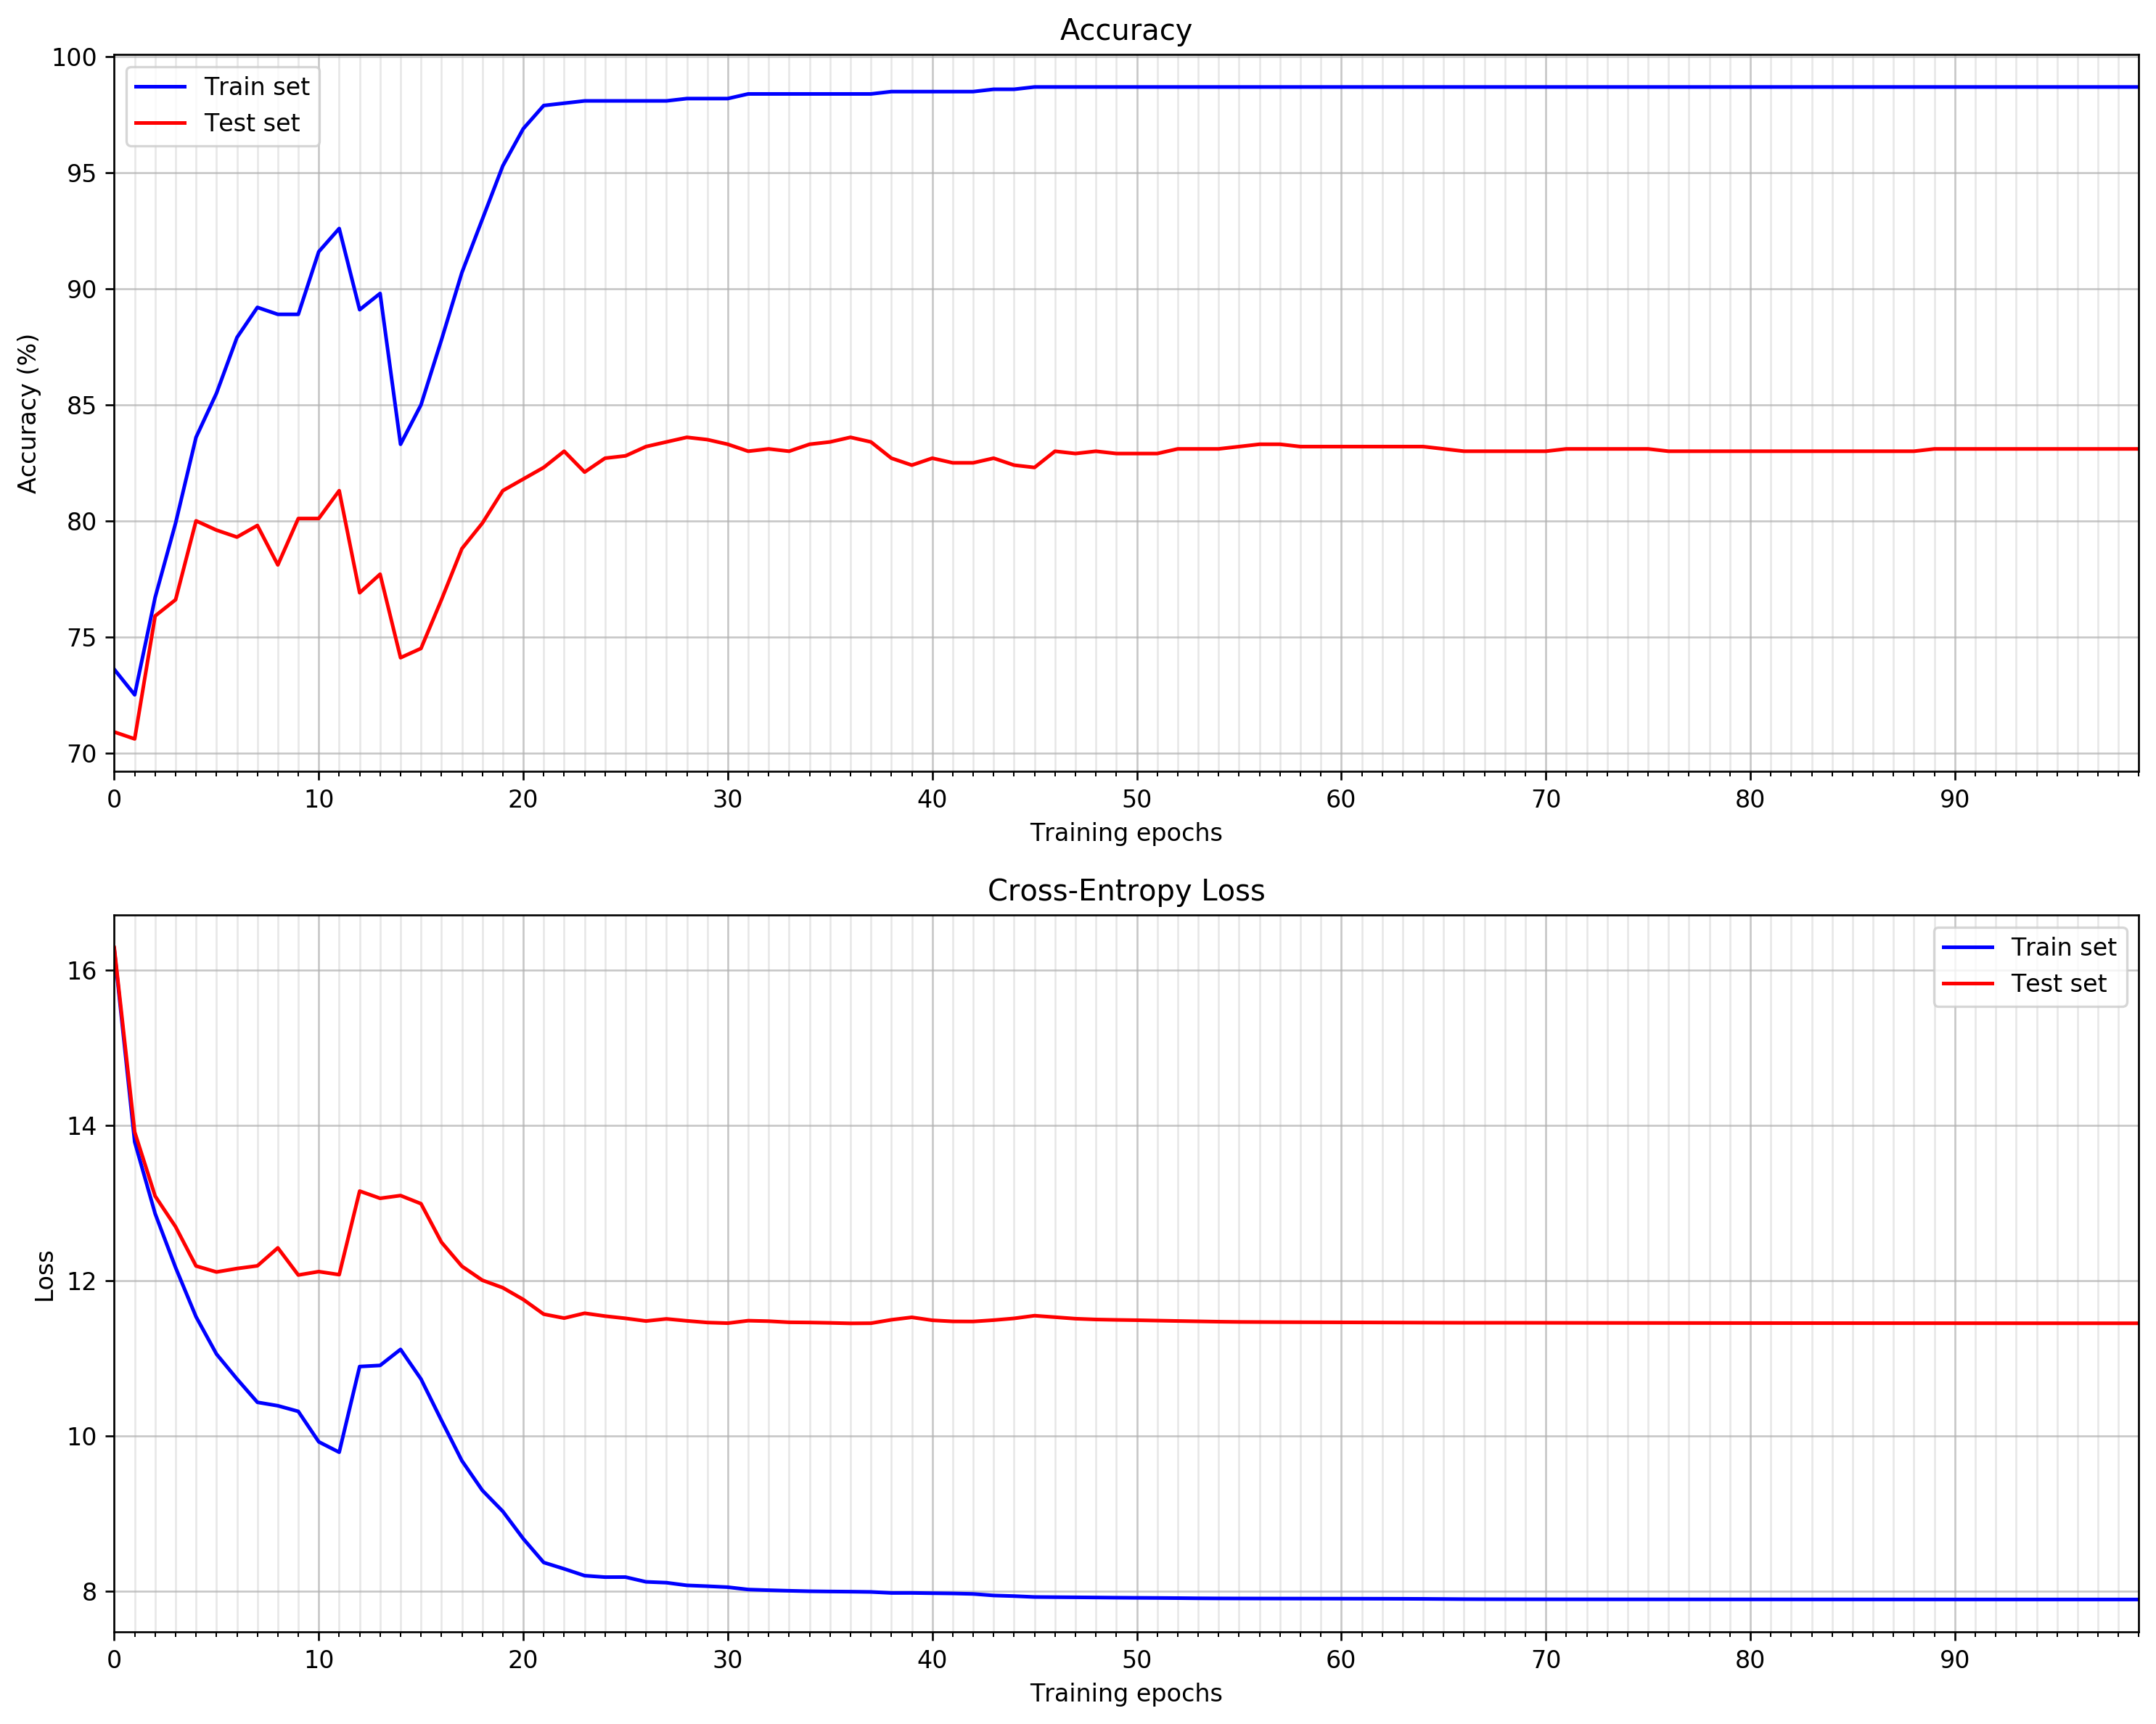

In [33]:
plot_acc_loss(train_accuracies, train_losses, test_accuracies, test_losses)

## 3. Testing model

_In order to test the model we will generate new data (training and test set), retrained the model on the new data en evaluate it on the new test set. We will do this process more than 10 times and estimates the mean accuracy as well as its standard deviation._

In [34]:
nb_rounds = 10

In [35]:
def evaluate_model(model, nb_rounds, criterion, device, batch_size, nb_epoch, optimizer_params, model_params = None, with_aux_loss = False, aux_loss_alpha = 0.5):
    
    accuracies = []
    
    for round in range(nb_rounds):
        
        # initialize new model
        if model_params != None:
        	model_evaluated = model(model_params).to(device)
        else:
        	model_evaluated = model().to(device)
        # generate new data
        train_input, train_target, train_classes, test_input, test_target, test_classes = generate_data_device(1000, device=device)
        train_input = normalize_data(train_input)
        test_input = normalize_data(test_input)
        
        train_model(model_evaluated,
                    train_input,
                    train_target,
                    train_classes,
                    None,
                    None,
                    None,
                    nb_epoch, batch_size, optimizer_params, False, with_aux_loss, aux_loss_alpha)
        
        accuracy, loss = test(test_input, test_target, test_classes, model_evaluated, criterion, batch_size, with_aux_loss, aux_loss_alpha)
        
        print("Round {i}: accuracy = {a:0.2f}% | loss = {l:0.4f}".format(i = (round + 1), a = accuracy, l = loss))
        
        accuracies.append(accuracy)
        
    return torch.FloatTensor(accuracies)

In [36]:
accuracies = evaluate_model(architecture,
                            nb_rounds,
                            nn.CrossEntropyLoss(),
                            device, BATCH_SIZE,
                            20,
                            {'lr': 0.1, 'momentum':0.9, 'weight_decay': 0.0, 'gamma': 0.97},
                            {'aux_loss': True},
                            with_aux_loss = with_aux_loss,
                            aux_loss_alpha = best_alpha)

Round 1: accuracy = 80.70% | loss = 10.3684
Round 2: accuracy = 83.60% | loss = 9.7747
Round 3: accuracy = 79.10% | loss = 10.7526
Round 4: accuracy = 79.30% | loss = 10.5648
Round 5: accuracy = 78.30% | loss = 10.8956
Round 6: accuracy = 76.80% | loss = 11.0587
Round 7: accuracy = 79.50% | loss = 10.5560
Round 8: accuracy = 74.90% | loss = 11.3136
Round 9: accuracy = 81.10% | loss = 10.2946
Round 10: accuracy = 80.00% | loss = 10.4575


In [37]:
print("The mean accuracy is: {a:0.2f}".format(a = accuracies.mean()))
print("The accuracy std is: {s:0.4f}".format(s = accuracies.std()))

The mean accuracy is: 79.33
The accuracy std is: 2.3772
